In [1]:
# ============================================================
# Yang Song-style Score-Based Diffusion (Educational PyTorch)
# End-to-end: data -> DSM training -> PC sampling -> visualization
# ============================================================

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt


In [2]:
# ----------------------------
# 0) Reproducibility helpers
# ----------------------------
def seed_all(seed: int = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
# ----------------------------
# 1) Config
# ----------------------------
@dataclass
class CFG:
    dataset: str = "MNIST"      # "MNIST" or "CIFAR10"
    data_root: str = "./data"
    out_dir: str = "./out_score_sde"
    batch_size: int = 128
    num_workers: int = 2
    img_size: int = 32          # we'll resize MNIST to 32x32 for U-Net convenience
    epochs: int = 5             # increase for better samples (e.g., 50+)
    lr: float = 2e-4
    grad_clip: float = 1.0

    # Noise schedule (multi-sigma, as in NCSN)
    sigma_max: float = 50.0
    sigma_min: float = 0.01
    num_sigmas: int = 20        # number of discrete noise levels
    # Sampling hyperparams
    n_steps_each: int = 1       # Langevin steps per sigma in corrector
    snr: float = 0.16           # typical 0.1~0.2
    predictor_step_factor: float = 1.0  # scales reverse SDE predictor steps
    # Training
    log_every: int = 200
    save_every_epochs: int = 1

cfg = CFG()
os.makedirs(cfg.out_dir, exist_ok=True)


In [5]:
# ----------------------------
# 2) Data
# ----------------------------
def get_dataloader(cfg: CFG):
    if cfg.dataset.upper() == "MNIST":
        channels = 1
        tfm = transforms.Compose([
            transforms.Resize(cfg.img_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x * 2.0 - 1.0),  # [-1,1]
        ])
        ds = datasets.MNIST(cfg.data_root, train=True, download=True, transform=tfm)
    elif cfg.dataset.upper() == "CIFAR10":
        channels = 3
        tfm = transforms.Compose([
            transforms.Resize(cfg.img_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x * 2.0 - 1.0),
        ])
        ds = datasets.CIFAR10(cfg.data_root, train=True, download=True, transform=tfm)
    else:
        raise ValueError("dataset must be MNIST or CIFAR10")

    dl = DataLoader(ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, drop_last=True)
    return dl, channels

dataloader, channels = get_dataloader(cfg)
print("Channels:", channels)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.30MB/s]

Channels: 1


In [6]:
# ----------------------------
# 3) Noise levels (sigmas)
#    NCSN uses geometric progression from sigma_max -> sigma_min
# ----------------------------
def make_sigmas(cfg: CFG, device):
    sigmas = torch.exp(torch.linspace(math.log(cfg.sigma_max), math.log(cfg.sigma_min), cfg.num_sigmas, device=device))
    return sigmas

sigmas = make_sigmas(cfg, device)

In [21]:
sigmas

tensor([5.0000e+01, 3.1937e+01, 2.0399e+01, 1.3029e+01, 8.3222e+00, 5.3157e+00,
        3.3953e+00, 2.1687e+00, 1.3852e+00, 8.8476e-01, 5.6512e-01, 3.6096e-01,
        2.3056e-01, 1.4726e-01, 9.4062e-02, 6.0080e-02, 3.8375e-02, 2.4511e-02,
        1.5656e-02, 1.0000e-02], device='cuda:0')

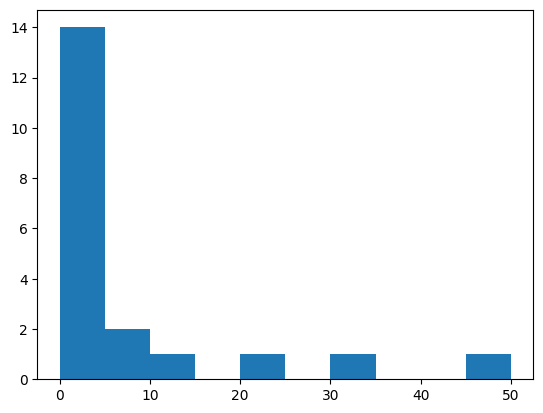

In [24]:
plt.hist(sigmas.cpu());

In [7]:
# ----------------------------
# 4) Time/Noise embedding (Fourier features)
# ----------------------------
class GaussianFourierProjection(nn.Module):
    """
    Random Fourier features for scalar conditioning (sigma or t).
    """
    def __init__(self, embed_dim: int = 64, scale: float = 16.0):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B] scalar
        x_proj = x[:, None] * self.W[None, :] * 2 * math.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)  # [B, embed_dim]


In [8]:
# ----------------------------
# 5) Simple U-Net blocks (educational)
# ----------------------------
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.emb = nn.Linear(emb_dim, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, emb):
        h = self.conv1(F.silu(self.norm1(x)))
        h = h + self.emb(F.silu(emb))[:, :, None, None]
        h = self.conv2(F.silu(self.norm2(h)))
        return h + self.skip(x)


In [9]:
class Down(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.op = nn.Conv2d(ch, ch, 4, stride=2, padding=1)
    def forward(self, x):
        return self.op(x)


In [10]:
class Up(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.op = nn.ConvTranspose2d(ch, ch, 4, stride=2, padding=1)
    def forward(self, x):
        return self.op(x)


In [11]:
class SimpleUNetScore(nn.Module):
    """
    Noise-Conditional Score Network (NCSN-like):
    input: noisy image x and sigma
    output: score s_theta(x, sigma) with same shape as x
    """
    def __init__(self, in_ch=1, base=64, emb_dim=128):
        super().__init__()
        self.fourier = GaussianFourierProjection(embed_dim=emb_dim)
        self.emb_mlp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.SiLU(),
            nn.Linear(emb_dim, emb_dim),
        )

        self.in_conv = nn.Conv2d(in_ch, base, 3, padding=1)

        # Down
        self.rb1 = ResBlock(base, base, emb_dim)
        self.down1 = Down(base)
        self.rb2 = ResBlock(base, base*2, emb_dim)
        self.down2 = Down(base*2)
        self.rb3 = ResBlock(base*2, base*4, emb_dim)

        # Middle
        self.mid1 = ResBlock(base*4, base*4, emb_dim)
        self.mid2 = ResBlock(base*4, base*4, emb_dim)

        # Up
        self.up2 = Up(base*4)
        self.rb4 = ResBlock(base*4 + base*2, base*2, emb_dim)
        self.up1 = Up(base*2)
        self.rb5 = ResBlock(base*2 + base, base, emb_dim)

        self.out_norm = nn.GroupNorm(8, base)
        self.out_conv = nn.Conv2d(base, in_ch, 3, padding=1)

    def forward(self, x, sigma):
        # sigma: [B] (noise level). We embed log sigma for stability.
        emb = self.emb_mlp(self.fourier(torch.log(sigma + 1e-8)))

        h0 = self.in_conv(x)
        h1 = self.rb1(h0, emb)
        d1 = self.down1(h1)
        h2 = self.rb2(d1, emb)
        d2 = self.down2(h2)
        h3 = self.rb3(d2, emb)

        m = self.mid2(self.mid1(h3, emb), emb)

        u2 = self.up2(m)
        u2 = torch.cat([u2, h2], dim=1)
        u2 = self.rb4(u2, emb)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, h1], dim=1)
        u1 = self.rb5(u1, emb)

        out = self.out_conv(F.silu(self.out_norm(u1)))
        return out


In [12]:
# Instantiate model
model = SimpleUNetScore(in_ch=channels).to(device)
opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)

In [13]:
# ----------------------------
# 6) DSM training loss (Song's key idea)
#    For each x0:
#      pick sigma (random among levels)
#      add noise: x = x0 + sigma * eps
#      target score: (x0 - x) / sigma^2 = -eps / sigma
#    loss: || s_theta(x, sigma) - target ||^2
# ----------------------------
def dsm_loss(model, x0, sigmas):
    B = x0.size(0)
    # sample discrete sigma indices
    idx = torch.randint(0, sigmas.numel(), (B,), device=x0.device)
    sigma = sigmas[idx]  # [B]
    # noise
    eps = torch.randn_like(x0)
    x = x0 + sigma[:, None, None, None] * eps
    # target score
    target = -eps / (sigma[:, None, None, None] + 1e-8)
    # predicted score
    pred = model(x, sigma)
    # (optional) weighting by sigma^2 (common in practice)
    # Here we keep it simple; you can try weight = sigma**2
    loss = ((pred - target) ** 2).reshape(B, -1).mean(dim=1).mean()
    return loss

In [14]:
# ----------------------------
# 7) Sampling: Predictor-Corrector (PC) sampler
#    - Corrector: Langevin dynamics steps at current sigma
#    - Predictor: Reverse SDE Euler-Maruyama step between sigmas
#
#    This is the "Song-style" sampler used in Score-SDE paper family.
# ----------------------------
@torch.no_grad()
def langevin_corrector(model, x, sigma, snr=0.16, n_steps=1):
    """
    Corrector: x <- x + step * score + noise
    step is chosen using SNR heuristic.
    """
    for _ in range(n_steps):
        score = model(x, sigma)
        noise = torch.randn_like(x)
        # step size based on SNR: step = (snr * ||noise|| / ||score||)^2
        # Use mean norms for stability
        grad_norm = torch.norm(score.reshape(score.shape[0], -1), dim=-1).mean()
        noise_norm = torch.norm(noise.reshape(noise.shape[0], -1), dim=-1).mean()
        step_size = (snr * noise_norm / (grad_norm + 1e-8)) ** 2
        x = x + step_size * score + torch.sqrt(2.0 * step_size) * noise
    return x

In [15]:
@torch.no_grad()
def reverse_sde_predictor(model, x, sigma, sigma_next, step_factor=1.0):
    """
    Reverse-time SDE predictor (VE formulation)
    """
    score = model(x, sigma)

    # reshape sigmas for broadcasting
    delta_sigma = (sigma_next - sigma)[:, None, None, None]

    # drift term
    drift = delta_sigma * score * step_factor

    # diffusion (noise) term
    noise_scale = torch.sqrt(torch.clamp(
        sigma[:, None, None, None]**2 - sigma_next[:, None, None, None]**2,
        min=0.0
    ))
    z = torch.randn_like(x)

    x = x + drift + noise_scale * z
    return x


In [16]:
@torch.no_grad()
def pc_sampler(model, shape, sigmas, n_steps_each=1, snr=0.16, step_factor=1.0):
    """
    Start from Gaussian noise at sigma_max, then iterate down to sigma_min.
    """
    B, C, H, W = shape
    x = torch.randn(shape, device=device) * sigmas[0]  # start at largest sigma
    for i in range(sigmas.numel() - 1):
        sigma = sigmas[i].repeat(B)
        sigma_next = sigmas[i+1].repeat(B)
        # Corrector (Langevin)
        x = langevin_corrector(model, x, sigma, snr=snr, n_steps=n_steps_each)
        # Predictor (reverse SDE step)
        x = reverse_sde_predictor(model, x, sigma, sigma_next, step_factor=step_factor)
    # final correction at sigma_min
    x = langevin_corrector(model, x, sigmas[-1].repeat(B), snr=snr, n_steps=n_steps_each)
    return x

In [17]:
# ----------------------------
# 8) Train loop + sampling snapshots
# ----------------------------
def denorm(x):
    # [-1,1] -> [0,1]
    return (x.clamp(-1, 1) + 1) / 2

def save_grid(x, path, nrow=8):
    grid = utils.make_grid(denorm(x), nrow=nrow)
    utils.save_image(grid, path)

def show_grid(x, title=""):
    grid = utils.make_grid(denorm(x), nrow=8).cpu()
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.axis("off")
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap="gray" if channels==1 else None)
    plt.show()

Device: cuda
Channels: 1
Epoch 1/5 | step 200 | loss 876.4238
Epoch 1/5 | step 400 | loss 576.3914
Saved: ./out_score_sde/score_unet_epoch1.pt
Epoch 1 done in 37.0s | samples -> ./out_score_sde/samples_epoch1.png
Epoch 2/5 | step 600 | loss 803.5329
Epoch 2/5 | step 800 | loss 578.6447
Saved: ./out_score_sde/score_unet_epoch2.pt
Epoch 2 done in 36.9s | samples -> ./out_score_sde/samples_epoch2.png
Epoch 3/5 | step 1000 | loss 397.2194
Epoch 3/5 | step 1200 | loss 582.7556
Epoch 3/5 | step 1400 | loss 316.9166
Saved: ./out_score_sde/score_unet_epoch3.pt
Epoch 3 done in 36.7s | samples -> ./out_score_sde/samples_epoch3.png
Epoch 4/5 | step 1600 | loss 258.3232
Epoch 4/5 | step 1800 | loss 447.1973
Saved: ./out_score_sde/score_unet_epoch4.pt
Epoch 4 done in 36.9s | samples -> ./out_score_sde/samples_epoch4.png
Epoch 5/5 | step 2000 | loss 393.9282
Epoch 5/5 | step 2200 | loss 357.6933
Saved: ./out_score_sde/score_unet_epoch5.pt
Epoch 5 done in 36.8s | samples -> ./out_score_sde/samples_ep

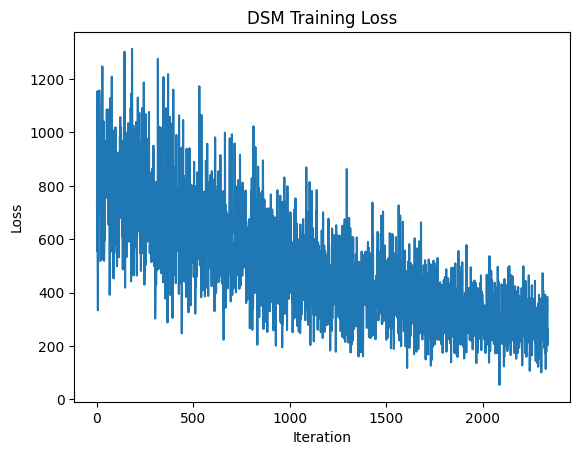

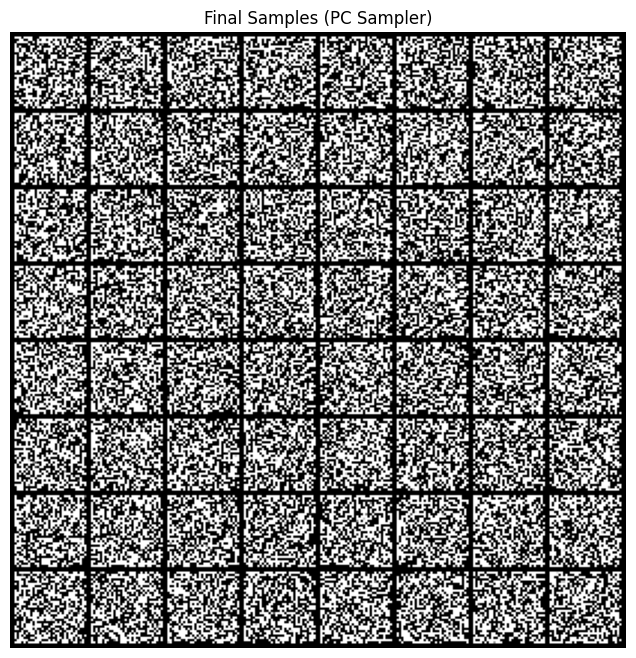

Done. Outputs in: ./out_score_sde


In [2]:
loss_hist = []
global_step = 0

for epoch in range(1, cfg.epochs + 1):
    model.train()
    t0 = time.time()
    for it, (x0, _) in enumerate(dataloader, start=1):
        x0 = x0.to(device)

        loss = dsm_loss(model, x0, sigmas)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        opt.step()

        loss_hist.append(loss.item())
        global_step += 1

        if global_step % cfg.log_every == 0:
            print(f"Epoch {epoch}/{cfg.epochs} | step {global_step} | loss {loss.item():.4f}")

    # Save checkpoint
    if epoch % cfg.save_every_epochs == 0:
        ckpt_path = os.path.join(cfg.out_dir, f"score_unet_epoch{epoch}.pt")
        torch.save({"model": model.state_dict(), "cfg": cfg.__dict__}, ckpt_path)
        print("Saved:", ckpt_path)

    # Sample a grid
    model.eval()
    with torch.no_grad():
        samples = pc_sampler(
            model,
            shape=(64, channels, cfg.img_size, cfg.img_size),
            sigmas=sigmas,
            n_steps_each=cfg.n_steps_each,
            snr=cfg.snr,
            step_factor=cfg.predictor_step_factor
        )
    img_path = os.path.join(cfg.out_dir, f"samples_epoch{epoch}.png")
    save_grid(samples, img_path, nrow=8)
    print(f"Epoch {epoch} done in {time.time()-t0:.1f}s | samples -> {img_path}")

In [ ]:
# Plot loss curve
plt.figure()
plt.plot(loss_hist)
plt.title("DSM Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# Display last samples
show_grid(samples, title="Final Samples (PC Sampler)")
print("Done. Outputs in:", cfg.out_dir)